In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH = "data/dogbreed/"

In [4]:
sz = 299
arch = resnext101_64
bs = 64
# Jeremy tried 224, 58 and 299, 58

In [5]:
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv))) - 1
val_idxs = get_cv_idxs(n)

In [6]:
!ls {PATH}

labels.csv  results  sample_submission.csv  test  tmp  train


In [7]:
label_df = pd.read_csv(label_csv)

In [ ]:
label_df.head()

In [ ]:
label_df.pivot_table(index='breed', aggfunc=len).sort_values('id', ascending=False)

In [8]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test',
                                    val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)

In [9]:
fn = PATH+data.trn_ds.fnames[0]; fn

'data/dogbreed/train/000bec180eb18c7604dcecc8fe0dba07.jpg'

In [ ]:
img = PIL.Image.open(fn); img

In [ ]:
img.size

In [10]:
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}

In [11]:
row_sz, col_sz = list(zip(*size_d.values()))

In [12]:
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

In [ ]:
plt.hist(row_sz)

(array([  148.,   600.,  1307.,  1205.,  4581.,   122.,    78.,    62.,    15.,     7.]),
 array([  97. ,  186.3,  275.6,  364.9,  454.2,  543.5,  632.8,  722.1,  811.4,  900.7,  990. ]),
 <a list of 10 Patch objects>)

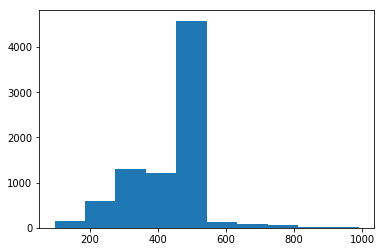

In [13]:
plt.hist(row_sz[row_sz < 1000])

In [ ]:
plt.hist(col_sz)

(array([  243.,   721.,  2218.,  2940.,  1837.,    95.,    29.,    29.,     8.,     8.]),
 array([ 102. ,  190.2,  278.4,  366.6,  454.8,  543. ,  631.2,  719.4,  807.6,  895.8,  984. ]),
 <a list of 10 Patch objects>)

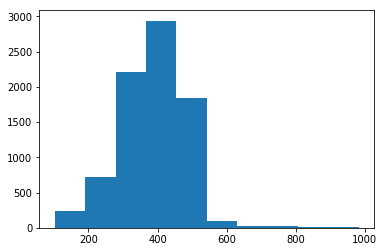

In [14]:
plt.hist(col_sz[col_sz < 1000])

In [15]:
len(data.trn_ds), len(data.test_ds)

(8178, 10357)

In [16]:
len(data.classes), data.classes[:5]

(120,
 ['affenpinscher',
  'afghan_hound',
  'african_hunting_dog',
  'airedale',
  'american_staffordshire_terrier'])

In [17]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test',
                                        val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)
    return data if sz>300 else data.resize(340, 'tmp')

## Precompute

In [18]:
data = get_data(sz, bs)

A Jupyter Widget

In [19]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [20]:
learn.lr_find()

A Jupyter Widget

 91%|█████████ | 116/128 [00:02<00:00, 45.53it/s, loss=11.9]


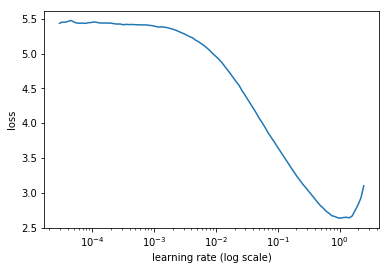

In [21]:
learn.sched.plot()

In [22]:
learn.fit(1e-2, 5)

A Jupyter Widget

[ 0.       1.10872  0.40916  0.91934]                       
[ 1.       0.4539   0.29623  0.92617]                        
[ 2.       0.29614  0.26372  0.9222 ]                         
[ 3.       0.22514  0.25435  0.92568]                        
[ 4.       0.18022  0.23816  0.92419]                         



## Augment

In [23]:
from sklearn import metrics

In [24]:
data = get_data(sz, bs)

A Jupyter Widget

In [25]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [26]:
learn.fit(1e-2, 2)

A Jupyter Widget

[ 0.       1.40131  0.48381  0.91439]                       
[ 1.       0.58774  0.32241  0.92227]                        



In [27]:
learn.precompute=False

In [28]:
learn.fit(1e-2, 5, cycle_len=1)

A Jupyter Widget

[ 0.       0.48817  0.28454  0.93249]                        
[ 1.       0.43865  0.26208  0.93444]                        
[ 2.       0.38876  0.24906  0.93398]                        
[ 3.       0.35905  0.24005  0.92904]                        
[ 4.       0.34425  0.2349   0.93154]                        



In [29]:
learn.save('299_pre')

In [30]:
learn.load('299_pre')

## Increase size

In [31]:
learn.set_data(get_data(340, bs))
learn.freeze()

In [32]:
learn.fit(1e-2, 3, cycle_len=1)

A Jupyter Widget

[ 0.       0.3122   0.23806  0.93301]                        
[ 1.       0.31282  0.2294   0.92861]                        
[ 2.       0.277    0.22677  0.93057]                        



In [33]:
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.26901  0.2193   0.93057]                        
[ 1.       0.25803  0.22228  0.92861]                        
[ 2.       0.23873  0.21727  0.93057]                        
[ 3.       0.24676  0.21469  0.92907]                        
[ 4.       0.22214  0.21017  0.93252]                        
[ 5.       0.20929  0.21075  0.93301]                        
[ 6.       0.20099  0.20861  0.93398]                        



In [34]:
log_preds, y = learn.TTA()
probs = np.exp(log_preds)
accuracy(log_preds, y), metrics.log_loss(y, probs)

(0.93737769080234834, 0.2067090669820284)

In [35]:
learn.save('340_pre')

In [36]:
learn.load('340_pre')

In [ ]:
learn.fit(1e-2, 1, cycle_len=2)

In [ ]:
learn.save('340_pre')

In [37]:
log_preds, y = learn.TTA(is_test=True)
probs = np.exp(log_preds)
#accuracy(log_preds, y), metrics.log_loss(y, probs)

## Use whole dataset now

In [ ]:
learn.load('299_pre')

In [ ]:
def get_data_whole(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test',
                                        val_idxs=[0], suffix='.jpg', tfms=tfms, bs=bs)
    return data if sz>300 else data.resize(340, 'tmp')

In [ ]:
learn.set_data(get_data_whole(299, bs))
learn.freeze()

In [ ]:
learn.fit(1e-2, 3, cycle_len=1)

In [ ]:
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

In [ ]:
log_preds, y = learn.TTA()
probs = np.exp(log_preds)
accuracy(log_preds, y), metrics.log_loss(y, probs)

In [ ]:
learn.save('299_pre')

In [ ]:
learn.load('299_pre')

In [ ]:
learn.fit(1e-2, 1, cycle_len=2)

In [ ]:
learn.save('299_pre')

In [ ]:
log_preds, y = learn.TTA()
probs = np.exp(log_preds)
accuracy(log_preds, y), metrics.log_loss(y, probs)

In [38]:
df = pd.DataFrame(probs)
df.columns = data.classes
df.insert(0, 'id', [o[5:-4] for o in data.test_ds.fnames])

In [39]:
df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,fd1a7be32f10493735555e62913c0841,4.287225e-06,3.613319e-06,4.613066e-07,2.896497e-06,5.595978e-07,2.773699e-07,1.287049e-07,1.488571e-07,5.508411e-07,...,5.992485e-06,2.689349e-07,4.405502e-07,3.276415e-07,2.009827e-07,8.937376e-07,1.016046e-07,7.870665e-08,1.613134e-06,3.783295e-07
1,5273d42f02b4715cb93845205995ef64,8.970855e-06,1.345246e-05,1.705383e-04,4.446631e-05,5.319148e-06,1.044389e-05,1.244973e-05,2.642605e-06,6.482987e-06,...,1.222443e-06,1.754370e-06,9.750102e-06,4.345707e-06,9.957707e-05,8.483146e-06,3.301356e-05,3.080703e-05,8.704243e-06,1.478597e-05
2,442057a3142f4d75a1023db363e2fb54,3.007447e-07,8.044602e-07,2.356659e-07,3.701503e-07,3.511376e-08,7.991283e-07,1.388664e-08,8.785571e-08,1.828688e-05,...,2.337774e-08,2.993127e-07,3.132995e-06,5.716115e-05,2.250113e-06,1.261955e-08,8.295213e-08,9.757720e-08,1.589880e-07,1.564655e-07
3,fb03302b030afd122e0f4936c158f6c1,9.923948e-05,4.155729e-06,1.479856e-07,9.139923e-08,9.673068e-07,2.319290e-07,6.601576e-07,3.231678e-07,9.316926e-07,...,1.240362e-04,4.704374e-07,8.811907e-07,2.057295e-07,2.363816e-07,9.852646e-07,2.056682e-06,1.281742e-07,1.646805e-06,3.009064e-04
4,511ca6e3539192aa5c8747bb697e0525,6.173777e-07,6.039418e-07,1.553159e-06,6.451219e-08,3.933704e-07,1.272659e-06,7.312102e-05,5.760430e-07,2.863305e-07,...,2.482115e-04,1.510341e-06,1.044025e-06,2.852605e-08,4.859608e-07,1.506586e-06,2.009222e-05,1.170023e-07,5.669373e-06,6.110603e-05


In [40]:
SUBM = f'{PATH}results_2/'
os.makedirs(SUBM, exist_ok=True)
df.to_csv(f'{SUBM}submission7.csv', index=False)
#df.to_csv(f'{SUBM}subm.gz', compression='gzip', index=False)

## Individual prediction

In [ ]:
fn = data.val_ds.fnames[0]

In [ ]:
fn

In [ ]:
Image.open(PATH+fn).resize((150, 150))

In [ ]:
trn_tfms, val_tfms = tfms_from_model(arch, sz)

In [ ]:
ds = FilesIndexArrayDataset([fn], np.array([0]), val_tfms, PATH)
dl = DataLoader(ds)
preds = learn.predict_dl(dl)
np.argmax(preds)

In [ ]:
im = trn_tfms(Image.open(PATH+fn))
preds = to_np(learn.model(V(T(im[None]).cude())))
np.argmax(preds)

In [ ]:
trn_tfms, val_tfms = tfms_from_model(arch, sz)

In [ ]:
im = trn_tfms(Image.open(PATH+fn))
preds = learn.predict_array(im[None])
np.argmax(preds)